# Customer Review Project - Qonto

## Problem statement

**_Context_**

Qonto is a digital neobank that is 100% online-only. It launched in France in 2017. It’s one of the banks designed purely for the business market, and it has been a roaring success, growing to over 20,000 business customers since. 

In this project I will show you how to realiaze an analysis to determine what customers think about Qonto and their SaaS.

**_Instructions_**

I made a Python script to scrape all review from Trustpilot, stock all the data in a Google Spreadsheets via API and process a word frequency analysis. 

Scraping was done with BeautifulSoup library. The analysis was done using nltk/matplotlib library.

1. Scrap website of trustpilot to get all the data necessary
2. Clear the data if necessary and Export data to a GS that we will conect via our API (This data will be stocked there and everytime we run this script, we will update the GS)
3. Analysis
4. Conclusions


## Scrap Website of Trustpilot

In [3]:
#Import necessary libraries
import requests
import re
import numpy as np
from bs4 import BeautifulSoup
from tqdm import tqdm

In [4]:
url = 'https://fr.trustpilot.com/review/qonto.com?page=2'
page = requests.get(url)
soup = BeautifulSoup(page.content)

In [5]:
nb_reviews_string = soup.find('span', class_="typography_typography__QgicV typography_bodysmall__irytL typography_color-gray-7__9Ut3K typography_weight-regular__TWEnf typography_fontstyle-normal__kHyN3 styles_text__W4hWi").text
nb_reviews = re.sub("[^0-9]","", nb_reviews_string)
print(f'The number of reviews for Qonto available on Truspilot is {nb_reviews}.')

The number of reviews for Qonto available on Truspilot is 5797.


In [ ]:
#Create list with number of pages (Important to update the range if the website has new review pages)
l = []
for i in range(1, 213):
    l.append(i)
print(l)

In [ ]:
#Get all review pages
urls = []
for i in l:
    url = 'https://fr.trustpilot.com/review/qonto.com?page={}'.format(i)
    urls.append(url)
urls

In [9]:
#Test 1 link
url_review_1 = urls[1]
page = requests.get(url_review_1)
print(page)
page_1 = BeautifulSoup(page.content)

<Response [200]>


In [10]:
#Informations to scrap
#Name
#Number of Reviews
#Country
#Rating
#Full comment
#Date

In [ ]:
#Build an empty dictionary to stock all the data
dic = {'name' : [], 'nb_reviews_page': [], 'rating' :[], 'commentaire' : [], 'date' : []}

#Loop to get the data for each review for all pages (urls) of the trustpilot website
for url in tqdm(urls) : 

    page = requests.get(url)
    product = BeautifulSoup(page.content)

    #NAME
    name = product.find_all('div', class_='typography_typography__QgicV typography_bodysmall__irytL typography_weight-medium__UNMDK typography_fontstyle-normal__kHyN3 styles_consumerName__dP8Um')
    for i in name :
        dic['name'].append(i.text)

    #NB Reviews // Country 
    liste = []
    nb_reviews_page = product.find_all('div', {'class':'typography_typography__QgicV typography_bodysmall__irytL typography_color-gray-6__TogX2 typography_weight-regular__TWEnf typography_fontstyle-normal__kHyN3 styles_detailsIcon__Fo_ua'})
    for y in nb_reviews_page:
        liste.append(y.text)
    for z in liste :
        if 'avis' in z:
            dic['nb_reviews_page'].append(z)
    #Reviews
    reviews = product.find_all('section', {'class' : 'styles_reviewContentwrapper__zH_9M'})
    for e in reviews:
        try : 
            dic['commentaire'].append(e.find('p', {'data-service-review-text-typography':'true'}).text)
        except : 
            dic['commentaire'].append(e.find('a', {'data-review-title-link':'true'}).text)
            
    #Date + Rating
    for u in reviews:
        #dic['date'].append(u.find('time', {'data-service-review-date-time-ago' : 'true'})['datetime'])
        try :
            dic['date'].append(u.find('time', {'data-service-review-date-time-ago' : 'true'})['datetime'])
            dic['rating'].append(float(u.find('div', {'class' :'styles_reviewHeader__iU9Px' })['data-service-review-rating']))
        except :
            pass;

In [12]:
#Verify lengih before printing
print(len(dic['name']))
print(len(dic['nb_reviews_page']))
print(len(dic['rating']))
print(len(dic['commentaire']))
print(len(dic['date']))

4231
4231
4231
4231
4231


In [13]:
import pandas as pd

In [14]:
#Clear Dataframe before saving it
df = pd.DataFrame(dic)
df['nb_reviews_page'] = df['nb_reviews_page'].str.replace(" avis","")

In [ ]:
#Count number of nan by column
df.isna().sum()

In [15]:
#Save doc on my folder
df.to_csv('data_Qonto_CSV.csv', encoding='utf-8', index=False)

In [16]:
print(len(df.values))

4231


## Export to GS

In [17]:
!pip install gspread==5.3.0;

In [18]:
import gspread

In [19]:
#Insert the path to your json account here
path = 'level-chassis-345709-4deccf52db36.json'
gc = gspread.service_account(filename=path)


In [20]:
#Insert the id of your spreadsheet where you wanna stock the data
file = gc.open_by_key('1Ju8TeGJtARGHnAL8LizQ31vBirCQKQixgvTvz42eRqg').sheet1
worksheet = file
worksheet

<Worksheet 'Feuille 1' id:0>

In [21]:
#This function is to clear the document every time we execute this script. Remove it if you wanna stock your data
worksheet.clear()

{'spreadsheetId': '1Ju8TeGJtARGHnAL8LizQ31vBirCQKQixgvTvz42eRqg',
 'clearedRange': "'Feuille 1'!A1:Z16000"}

In [ ]:
worksheet.append_row(list(df.columns))

In [ ]:
#Its necessary to fill df with '' because does not accept nans
df = df.fillna('')

In [24]:
worksheet.update('A2', df.values.tolist())

{'spreadsheetId': '1Ju8TeGJtARGHnAL8LizQ31vBirCQKQixgvTvz42eRqg',
 'updatedRange': "'Feuille 1'!A2:E4232",
 'updatedRows': 4231,
 'updatedColumns': 5,
 'updatedCells': 21155}

In [25]:
#Check your spreadsheets
#url = https://docs.google.com/spreadsheets/d/1Ju8TeGJtARGHnAL8LizQ31vBirCQKQixgvTvz42eRqg/edit?usp=sharing

## Analysis

In [27]:
from nltk.corpus import stopwords

final_stopwords_list = stopwords.words('french')

In [61]:
#There still a lot of stop words, so we will add them to our dictionary and clear again the df
extra_words = ['a', 'cest', 'je', 'bonjouroui', 'leurs', 'foidtrès', 'jai']

In [62]:
final_stopwords = final_stopwords_list + extra_words
final_stopwords

['au',
 'aux',
 'avec',
 'ce',
 'ces',
 'dans',
 'de',
 'des',
 'du',
 'elle',
 'en',
 'et',
 'eux',
 'il',
 'ils',
 'je',
 'la',
 'le',
 'les',
 'leur',
 'lui',
 'ma',
 'mais',
 'me',
 'même',
 'mes',
 'moi',
 'mon',
 'ne',
 'nos',
 'notre',
 'nous',
 'on',
 'ou',
 'par',
 'pas',
 'pour',
 'qu',
 'que',
 'qui',
 'sa',
 'se',
 'ses',
 'son',
 'sur',
 'ta',
 'te',
 'tes',
 'toi',
 'ton',
 'tu',
 'un',
 'une',
 'vos',
 'votre',
 'vous',
 'c',
 'd',
 'j',
 'l',
 'à',
 'm',
 'n',
 's',
 't',
 'y',
 'été',
 'étée',
 'étées',
 'étés',
 'étant',
 'étante',
 'étants',
 'étantes',
 'suis',
 'es',
 'est',
 'sommes',
 'êtes',
 'sont',
 'serai',
 'seras',
 'sera',
 'serons',
 'serez',
 'seront',
 'serais',
 'serait',
 'serions',
 'seriez',
 'seraient',
 'étais',
 'était',
 'étions',
 'étiez',
 'étaient',
 'fus',
 'fut',
 'fûmes',
 'fûtes',
 'furent',
 'sois',
 'soit',
 'soyons',
 'soyez',
 'soient',
 'fusse',
 'fusses',
 'fût',
 'fussions',
 'fussiez',
 'fussent',
 'ayant',
 'ayante',
 'ayantes',


In [63]:
#We create a copy to do not modify main dataframe
df_test = df.copy()

In [64]:
# We remove all stopwrods in order to have a clean test
df_test['commentaire_sans_stop_words'] = df_test['commentaire'].apply(lambda x: ' '.join([word for word in x.split() if word not in (final_stopwords)]))

In [ ]:
df_test['commentaire_sans_stop_words'][1]

In [ ]:
#Since we want to get the Word Frequency it is better to convert the text to a lower case and to remove the punctuations.
df_test['commentaire_sans_stop_words'] = df_test['commentaire_sans_stop_words'].str.lower().str.replace('[^\w\s]','')

new_df = df_test.commentaire_sans_stop_words.str.split(expand=True).stack().value_counts().reset_index()
 
new_df.columns = ['All_Word', 'Frequency'] 
 
new_df.head(25)

In [91]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from os import path
from wordcloud import WordCloud

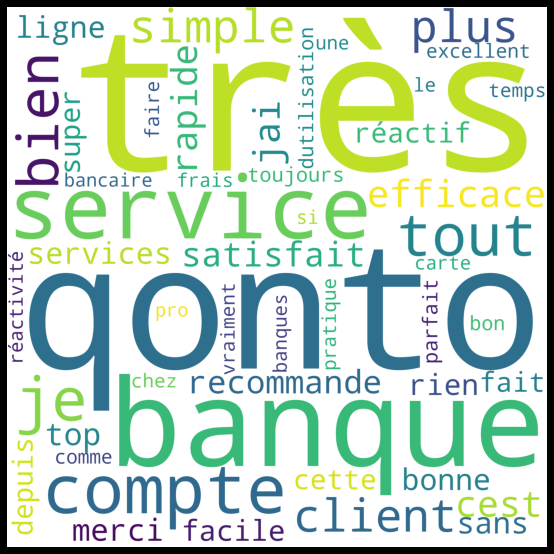

In [92]:
word_freq = dict(zip(new_df.All_Word, new_df.Frequency))

wc = WordCloud(background_color="white",width=2000,height=2000, max_words=50,relative_scaling=0.4,normalize_plurals=False).generate_from_frequencies(word_freq)

#plt.imshow(wc)

plt.figure( figsize=(15,7.5), facecolor='k')
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [93]:
#Same analysis with only negative review (1, 2 or 3 Rating)
negative_ratings = [1, 2, 3]
df_test_negative_reviews = df_test[df_test.rating.isin(negative_ratings)]
df_test_negative_reviews.shape

(314, 6)

In [ ]:
new_df_2 = df_test_negative_reviews.commentaire_sans_stop_words.str.split(expand=True).stack().value_counts().reset_index()
 
new_df_2.columns = ['Negative_Words', 'Frequency'] 
 
new_df_2.head(25)

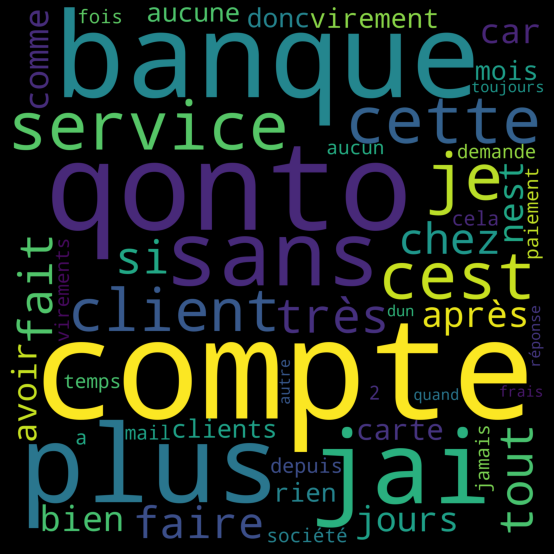

In [98]:
word_freq = dict(zip(new_df_2.Negative_Words, new_df.Frequency))

wc = WordCloud(background_color="black",width=2000,height=2000, max_words=50,relative_scaling=0.4,normalize_plurals=False).generate_from_frequencies(word_freq)

#plt.imshow(wc)

plt.figure( figsize=(15,7.5), facecolor='k')
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Conclusion

The most relevant words that Qonto customers use to describe their experience are:

**-trèes, qonto, banque, service, compte, tout, bien, simple, efficace, rapide, satisfait, recommande**

With this analysis we can confirm that customers are very satisfied and the 4.8 average ranking that Qonto has in Trustpilot is totally justified.

If we repeat this analysis for only the negative reviews (1,2 and 3 ratings) use see that the most frequent words customers use are:

**-compte, qonto, banque, sans, service, client**

We can conclude that customers that leave a negative review is normally related to an issue with their bank account and/or problems with the customer service.

Analyzing these results, we can conclude that most customers are satisfied wih Qonto service but they should fix the issues related with their Customer Service and the main issues that customers have with their Qonto account.

## Ideas:

-automatise this analysis and schedule a task to run it and send the results every month with the new customer reviews in order to track
to track the customer satisfaction.

-schedule this task and send a notification everytime we indentify a negative review to contant the customer and help him

-we can use the spreadsheets where we stocked all the data to conduct other analysis if necessary

Link: https://docs.google.com/spreadsheets/d/1Ju8TeGJtARGHnAL8LizQ31vBirCQKQixgvTvz42eRqg/edit#gid=0